In [ ]:
!pip install -q pytesseract opencv-python transformers datasets scikit-learn gradio streamlit pyngrok
!apt-get -qq update && apt-get -qq install tesseract-ocr tesseract-ocr-tam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.1 MB/s eta 0:00:00
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package tesseract-ocr-tam.
(Reading database ... 126281 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-tam_1%3a4.00~git30-7274cfa-1.1_all.deb ...
Unpacking tesseract-ocr-tam (1:4.00~git30-7274cfa-1.1) ...
Setting up tesseract-ocr-tam (1:4.00~git30-7274cfa-1.1) ...


In [ ]:
import os
import cv2
import zipfile
import pytesseract
import numpy as np
from google.colab import files

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
import joblib
from pyngrok import ngrok
import time

In [ ]:
uploaded = files.upload()
zip_filename = next(iter(uploaded))
with zipfile.ZipFile(zip_filename, "r") as zip_ref:
    zip_ref.extractall(".")
print(f"Unzipped: {zip_filename}")

Saving Images-30 (05).zip to Images-30 (05).zip
Unzipped: Images-30 (05).zip


In [ ]:
pytesseract.pytesseract.tesseract_cmd = "/usr/bin/tesseract"
OCR_LANG = "tam"

def preprocess_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.medianBlur(gray, 3)
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh

def image_to_text(path):
    img = cv2.imread(path)
    clean = preprocess_image(img)
    return pytesseract.image_to_string(clean, config="--oem 3 --psm 6 -l tam").strip()

def extract_texts(base_folder="Images-30 (05)", out_folder="extracted_texts"):
    os.makedirs(out_folder, exist_ok=True)
    for split in ["Train", "Test"]:
        split_path = os.path.join(base_folder, split)
        for author in os.listdir(split_path):
            author_path = os.path.join(split_path, author)
            if not os.path.isdir(author_path):
                continue
            dest = os.path.join(out_folder, f"{split}_{author}")
            os.makedirs(dest, exist_ok=True)
            for fname in os.listdir(author_path):
                if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                    txt = image_to_text(os.path.join(author_path, fname))
                    with open(os.path.join(dest, fname.rsplit(".", 1)[0] + ".txt"), "w", encoding="utf-8") as f:
                        f.write(txt)

extract_texts()
print("OCR finished and texts saved under ./extracted_texts")

OCR finished and texts saved under ./extracted_texts


In [ ]:
def load_dataset(dir_path="extracted_texts"):
    texts, labels = [], []
    for item in os.listdir(dir_path):
        sp = item.split("_", 1)
        if len(sp) != 2:
            continue
        split, author = sp
        folder = os.path.join(dir_path, item)
        for f in os.listdir(folder):
            if f.endswith(".txt"):
                with open(os.path.join(folder, f), encoding="utf-8") as fp:
                    texts.append(fp.read().strip())
                labels.append(author)
    return texts, labels

texts_all, labels_all = load_dataset()
le = LabelEncoder()
y_all = le.fit_transform(labels_all)
print("Classes:", le.classes_)

Classes: ['Karuvoorar' 'Konganar' 'Pambatti_siddhar' 'Theraiyar' 'agasthiyar']


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")
ibert = AutoModel.from_pretrained("ai4bharat/indic-bert").to(device)

@torch.inference_mode()
def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True, padding="max_length")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    out = ibert(**inputs).last_hidden_state
    mask = inputs["attention_mask"].unsqueeze(-1)
    pooled = (out * mask).sum(1) / mask.sum(1)
    return pooled.squeeze().cpu().numpy()

def split_embeddings(split_name="Train"):
    X, y = [], []
    prefix = split_name + "_"
    for item in os.listdir("extracted_texts"):
        if not item.startswith(prefix):
            continue
        author = item[len(prefix):]
        for f in os.listdir(os.path.join("extracted_texts", item)):
            if f.endswith(".txt"):
                with open(os.path.join("extracted_texts", item, f), encoding="utf-8") as fp:
                    X.append(get_embedding(fp.read().strip()))
                y.append(author)
    return np.vstack(X), le.transform(y)

X_train, y_train = split_embeddings("Train")
X_test, y_test = split_embeddings("Test")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/135M [00:00<?, ?B/s]


==== LogisticRegression ====
Accuracy: 0.8400
                  precision    recall  f1-score   support

      Karuvoorar       0.83      0.50      0.62        10
        Konganar       0.71      1.00      0.83        10
Pambatti_siddhar       0.82      0.90      0.86        10
       Theraiyar       0.90      0.90      0.90        10
      agasthiyar       1.00      0.90      0.95        10

        accuracy                           0.84        50
       macro avg       0.85      0.84      0.83        50
    weighted avg       0.85      0.84      0.83        50



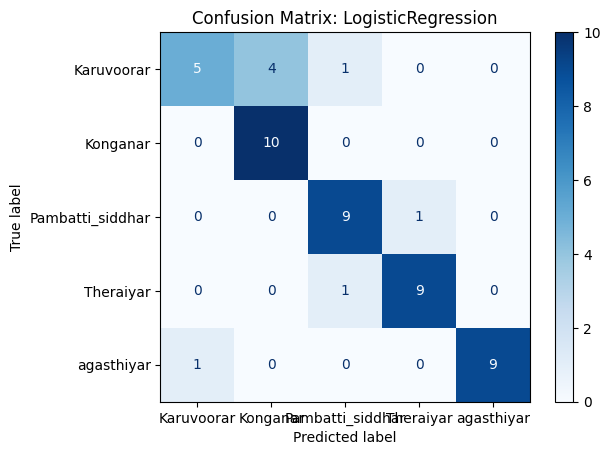


==== SVM ====
Accuracy: 0.7800
                  precision    recall  f1-score   support

      Karuvoorar       1.00      0.40      0.57        10
        Konganar       0.59      1.00      0.74        10
Pambatti_siddhar       0.71      1.00      0.83        10
       Theraiyar       1.00      0.60      0.75        10
      agasthiyar       1.00      0.90      0.95        10

        accuracy                           0.78        50
       macro avg       0.86      0.78      0.77        50
    weighted avg       0.86      0.78      0.77        50



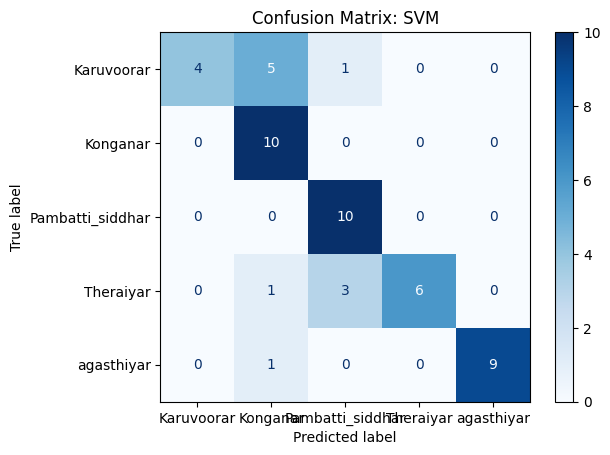


==== NaiveBayes ====
Accuracy: 0.7200
                  precision    recall  f1-score   support

      Karuvoorar       0.75      0.30      0.43        10
        Konganar       0.53      0.90      0.67        10
Pambatti_siddhar       0.73      0.80      0.76        10
       Theraiyar       0.78      0.70      0.74        10
      agasthiyar       1.00      0.90      0.95        10

        accuracy                           0.72        50
       macro avg       0.76      0.72      0.71        50
    weighted avg       0.76      0.72      0.71        50



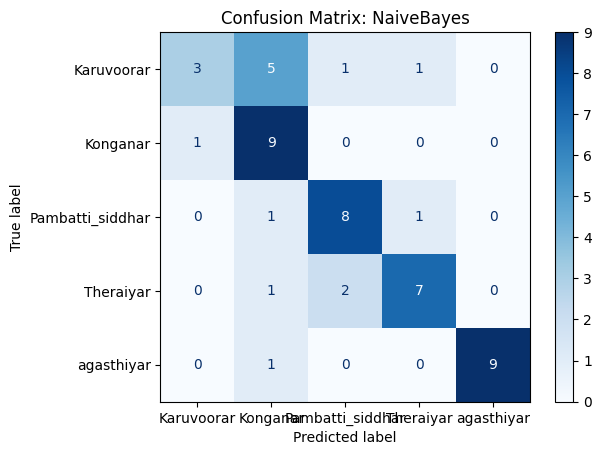


==== RandomForest ====
Accuracy: 0.7400
                  precision    recall  f1-score   support

      Karuvoorar       0.62      0.50      0.56        10
        Konganar       0.50      0.80      0.62        10
Pambatti_siddhar       0.82      0.90      0.86        10
       Theraiyar       1.00      0.60      0.75        10
      agasthiyar       1.00      0.90      0.95        10

        accuracy                           0.74        50
       macro avg       0.79      0.74      0.75        50
    weighted avg       0.79      0.74      0.75        50



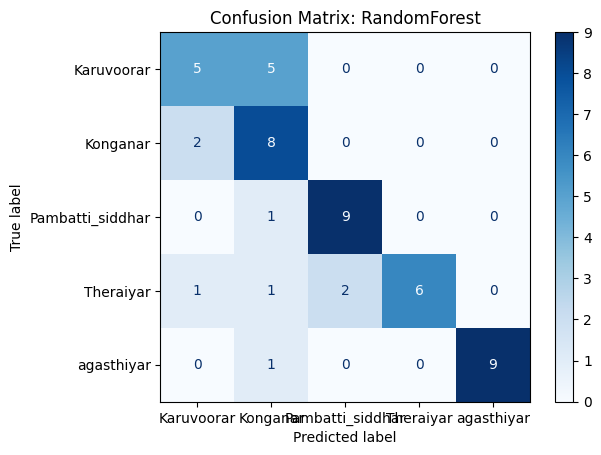


==== KNN ====
Accuracy: 0.7600
                  precision    recall  f1-score   support

      Karuvoorar       0.60      0.60      0.60        10
        Konganar       0.67      1.00      0.80        10
Pambatti_siddhar       0.86      0.60      0.71        10
       Theraiyar       0.78      0.70      0.74        10
      agasthiyar       1.00      0.90      0.95        10

        accuracy                           0.76        50
       macro avg       0.78      0.76      0.76        50
    weighted avg       0.78      0.76      0.76        50



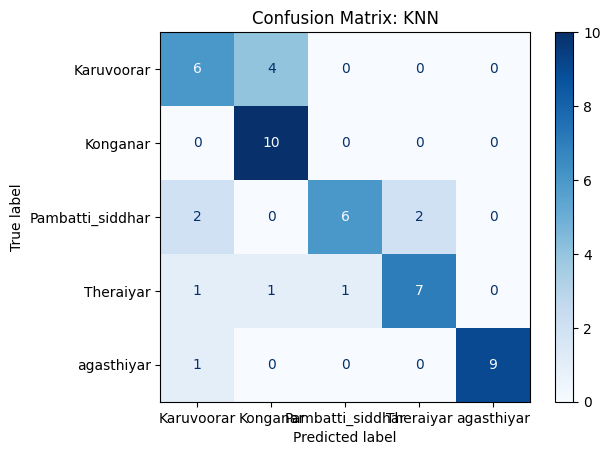


==== MLP ====
Accuracy: 0.9400
                  precision    recall  f1-score   support

      Karuvoorar       1.00      0.90      0.95        10
        Konganar       0.91      1.00      0.95        10
Pambatti_siddhar       0.90      0.90      0.90        10
       Theraiyar       0.91      1.00      0.95        10
      agasthiyar       1.00      0.90      0.95        10

        accuracy                           0.94        50
       macro avg       0.94      0.94      0.94        50
    weighted avg       0.94      0.94      0.94        50



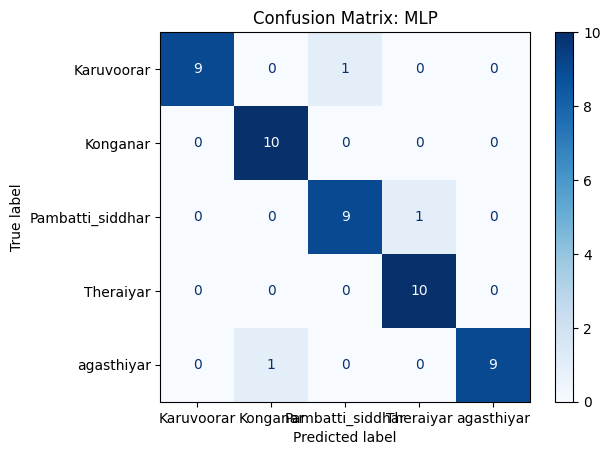


==== VotingClassifier ====
Accuracy: 0.9200
                  precision    recall  f1-score   support

      Karuvoorar       1.00      0.80      0.89        10
        Konganar       0.83      1.00      0.91        10
Pambatti_siddhar       0.90      0.90      0.90        10
       Theraiyar       0.91      1.00      0.95        10
      agasthiyar       1.00      0.90      0.95        10

        accuracy                           0.92        50
       macro avg       0.93      0.92      0.92        50
    weighted avg       0.93      0.92      0.92        50



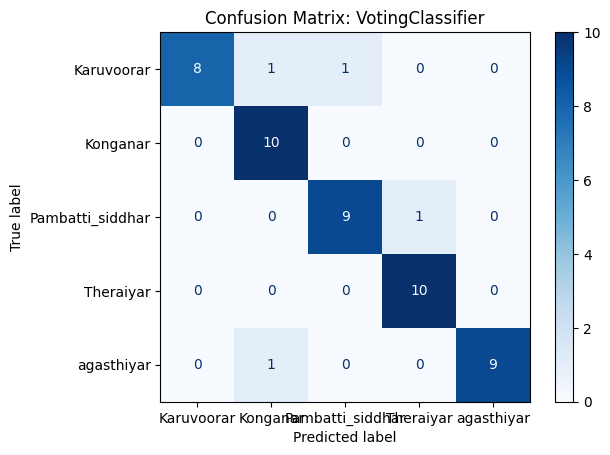


==== BaggingClassifier ====
Accuracy: 0.8400
                  precision    recall  f1-score   support

      Karuvoorar       0.83      0.50      0.62        10
        Konganar       0.67      1.00      0.80        10
Pambatti_siddhar       0.90      0.90      0.90        10
       Theraiyar       0.90      0.90      0.90        10
      agasthiyar       1.00      0.90      0.95        10

        accuracy                           0.84        50
       macro avg       0.86      0.84      0.83        50
    weighted avg       0.86      0.84      0.83        50



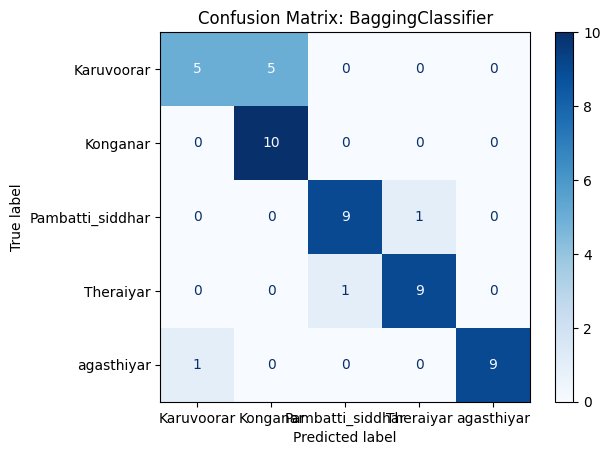


==== GradientBoosting ====
Accuracy: 0.7600
                  precision    recall  f1-score   support

      Karuvoorar       0.80      0.40      0.53        10
        Konganar       0.60      0.90      0.72        10
Pambatti_siddhar       0.75      0.90      0.82        10
       Theraiyar       0.78      0.70      0.74        10
      agasthiyar       1.00      0.90      0.95        10

        accuracy                           0.76        50
       macro avg       0.79      0.76      0.75        50
    weighted avg       0.79      0.76      0.75        50



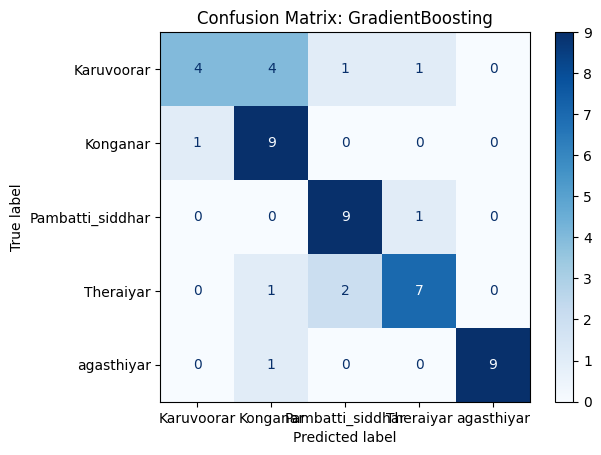


==== AdaBoost ====
Accuracy: 0.6600
                  precision    recall  f1-score   support

      Karuvoorar       0.56      0.50      0.53        10
        Konganar       0.64      0.90      0.75        10
Pambatti_siddhar       0.71      0.50      0.59        10
       Theraiyar       0.54      0.70      0.61        10
      agasthiyar       1.00      0.70      0.82        10

        accuracy                           0.66        50
       macro avg       0.69      0.66      0.66        50
    weighted avg       0.69      0.66      0.66        50



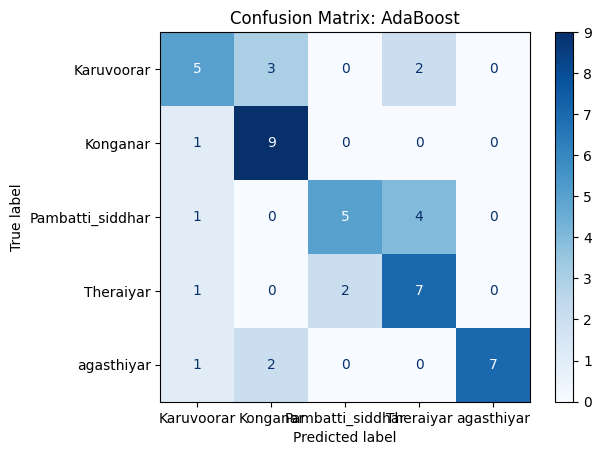


==== StackingClassifier ====
Accuracy: 0.9400
                  precision    recall  f1-score   support

      Karuvoorar       0.90      0.90      0.90        10
        Konganar       1.00      1.00      1.00        10
Pambatti_siddhar       0.90      0.90      0.90        10
       Theraiyar       0.91      1.00      0.95        10
      agasthiyar       1.00      0.90      0.95        10

        accuracy                           0.94        50
       macro avg       0.94      0.94      0.94        50
    weighted avg       0.94      0.94      0.94        50



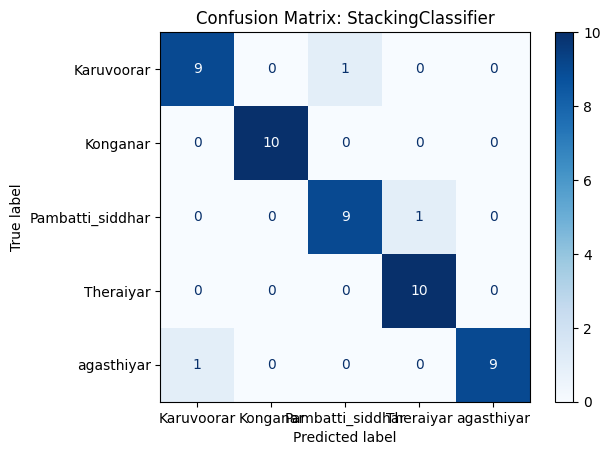


 Best Model: MLPClassifier with Accuracy: 0.9400


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    BaggingClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    VotingClassifier,
    StackingClassifier
)
from sklearn.neural_network import MLPClassifier

# Base Models
logreg = LogisticRegression(max_iter=1000)
svc = SVC(probability=True)
nb = GaussianNB()
knn = KNeighborsClassifier()
rf = RandomForestClassifier()
mlp = MLPClassifier(max_iter=500, random_state=42)

# Ensemble Models
voting = VotingClassifier(
    estimators=[("lr", logreg), ("rf", rf), ("mlp", mlp)],
    voting='soft'
)

bagging = BaggingClassifier(estimator=logreg, n_estimators=10, random_state=42)

gradient_boost = GradientBoostingClassifier(n_estimators=100)

adaboost = AdaBoostClassifier(n_estimators=50, random_state=42)

stacking = StackingClassifier(
    estimators=[("lr", logreg), ("nb", nb), ("mlp", mlp)],
    final_estimator=RandomForestClassifier()
)

# Model Dictionary
models = {
    "LogisticRegression": logreg,
    "SVM": svc,
    "NaiveBayes": nb,
    "RandomForest": rf,
    "KNN": knn,
    "MLP": mlp,
    "VotingClassifier": voting,
    "BaggingClassifier": bagging,
    "GradientBoosting": gradient_boost,
    "AdaBoost": adaboost,
    "StackingClassifier": stacking
}

# Evaluate All Models
best_model = None
best_acc = 0

for name, model in models.items():
    print(f"\n==== {name} ====")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, preds, target_names=le.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix: {name}")
    plt.grid(False)
    plt.show()

    if acc > best_acc:
        best_acc = acc
        best_model = model

print(f"\n Best Model: {best_model.__class__.__name__} with Accuracy: {best_acc:.4f}")


In [ ]:
with open("app.py", "w", encoding="utf-8") as f:
    f.write("""
import gradio as gr
import cv2
import numpy as np
import pytesseract
import torch
import joblib
from transformers import AutoTokenizer, AutoModel
from PIL import Image

# Load saved components
MODEL_PATH = "siddhar-author-model"
model = joblib.load(f"{MODEL_PATH}/model.pkl")
le = joblib.load(f"{MODEL_PATH}/label_encoder.pkl")
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
ibert = AutoModel.from_pretrained(MODEL_PATH)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ibert.to(device)

pytesseract.pytesseract.tesseract_cmd = "/usr/bin/tesseract"
OCR_LANG = "tam"

def preprocess_image(image):
    img = np.array(image)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur = cv2.medianBlur(gray, 3)
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh

def image_to_text(img_array):
    processed = preprocess_image(img_array)
    return pytesseract.image_to_string(processed, config="--oem 3 --psm 6 -l tam").strip()

@torch.inference_mode()
def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding="max_length")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    out = ibert(**inputs).last_hidden_state
    mask = inputs["attention_mask"].unsqueeze(-1)
    pooled = (out * mask).sum(1) / mask.sum(1)
    return pooled.squeeze().cpu().numpy()

def predict(image):
    text = image_to_text(image)
    if not text.strip():
        return "No Tamil text found in the image.", ""
    emb = get_embedding(text).reshape(1, -1)
    pred = model.predict(emb)[0]
    author = le.inverse_transform([pred])[0]
    return f"**Predicted Author**: {author}", text

demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[gr.Markdown(label="Author Prediction"), gr.Textbox(label="Extracted Text")],
    title="Tamil Siddhar Authorship Attribution",
    description="Upload a Tamil Siddhar poetry image. The model will extract text using OCR and predict the author."
)

if __name__ == "__main__":
    demo.launch()
    """)

In [ ]:
with open("requirements.txt", "w") as f:
    f.write("""gradio
pytesseract
opencv-python
transformers
torch
scikit-learn
joblib
""")

In [ ]:
from google.colab import files
files.download("app.py")
files.download("requirements.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os

SAVE_DIR = "siddhar-author-model"
os.makedirs(SAVE_DIR, exist_ok=True)

# Save the best model and label encoder
joblib.dump(best_model, f"{SAVE_DIR}/model.pkl")
joblib.dump(le, f"{SAVE_DIR}/label_encoder.pkl")

# Save tokenizer and model from Hugging Face
tokenizer.save_pretrained(SAVE_DIR)
ibert.save_pretrained(SAVE_DIR)

# Zip everything for download
import shutil
shutil.make_archive("siddhar-author-model", 'zip', SAVE_DIR)

# Download the zip file
files.download("siddhar-author-model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>